In [1]:
import numpy as np
import json
from pprint import pprint

from collections import defaultdict
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()


import seaborn as sns

import sys
sys.path.append('/projects2/refer360test/src')
sys.path.append('/projects2/lxmert/src/')

import os
from tqdm import tqdm
from utils import rad2degree
from utils import coord_gaussian
from panoramic_camera import PanoramicCamera as camera
import cv2
from scipy.spatial import Delaunay



In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

In [2]:
def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    #IPython.display.display(i)

In [3]:
def generate_grid(full_w=4552,
                  full_h=2276,
                  degree = 15):
  left_w = int(full_w * (degree/360)+1)
  
  dx = full_w * (degree/360)
  dy = full_h * (degree/180)
  DISTANCE = (dx ** 2 + dy ** 2) ** 0.5 + 10
  print('left_w',left_w)
  print('dx',dx)
  print('dy',dy)
  print('distance',DISTANCE)

  
  font = cv2.FONT_HERSHEY_SIMPLEX
  size = 10

  objects = []
  nodes = []

  slat, slng = rad2degree(np.random.uniform(
      0, 6), np.random.uniform(1, 1.5), adjust=True)
  sx = int(full_w * ((slat + 180)/360.0))
  sy = int(full_h - full_h *
           ((slng + 90)/180.0))

  # objects.append((slat, slng, -1, sx, sy, [sx-1, sy-1, sx+1, sy+1]))
  # nodes.append([sx, sy])

  for lng in range(-75, 75, degree):
    for lat in range(0, 360, degree): 
      gt_x = int(full_w * ((lat)/360.0))
      gt_y = int(full_h - full_h * ((lng + 90)/180.0))
      #canvas[gt_y-size:gt_y+size,gt_x-size:gt_x+size] = 1.0

      objects.append((lat, lng, 2, gt_x, gt_y, []))
      nodes.append([gt_x, gt_y])

  canvas = np.zeros((full_h, full_w, 3), dtype='uint8')

  clr = (255, 0, 0)

  node_dict = dict()
  for kk, o in enumerate(objects):
    o_type, ox, oy = o[2], o[3], o[4]
    o_label = '<START>'
    if o_type > 0:
      o_label = ''

    #cv2.putText(canvas, o_label, (ox+size, oy+size), font, 3, clr, 5)
    n = {
        'id': kk,
        'lat': o[0],
        'lng': o[1],
        'obj_label': o_label,
        'obj_id': o_type,
        'x': o[3],
        'y': o[4],
        'boxes': o[5],
        'neighbors': []
    }
    node_dict[kk] = n

  color = (125, 125, 125)
  
  
  n_nodes = len(nodes)
  order2nid = {i: i for i in range(n_nodes)}

  idx = n_nodes
  new_nodes = nodes
  for ii, n in enumerate(nodes):
    if n[0] < left_w:
      order2nid[idx] = ii
      new_nodes.append((n[0]+full_w, n[1]))
      idx += 1

  for ii,s1 in enumerate(new_nodes):
    for jj, s2 in enumerate(new_nodes):
      if ii == jj:
        continue
      
      d = ((s1[0]-s2[0])**2 + (s1[1]-s2[1])**2)**0.5
      if d <= DISTANCE:
        
        n0 = order2nid[ii]
        n1 = order2nid[jj]

        node_dict[n0]['neighbors'] += [n1]
        node_dict[n1]['neighbors'] += [n0]

        cv2.line(canvas, (s1[0], s1[1]),
               (s2[0], s2[1]), color, 3, 8)
  for kk, o in enumerate(objects):
    o_type, ox, oy = o[2], o[3], o[4]

    canvas[oy-size:oy+size, ox-size:ox+size, 0] = 255.
    canvas[oy-size:oy+size, ox-size:ox+size, 1:] = 0
    
  return node_dict, canvas    

left_w 253
dx 252.88888888888889
dy 252.88888888888889
distance 367.6388964401294


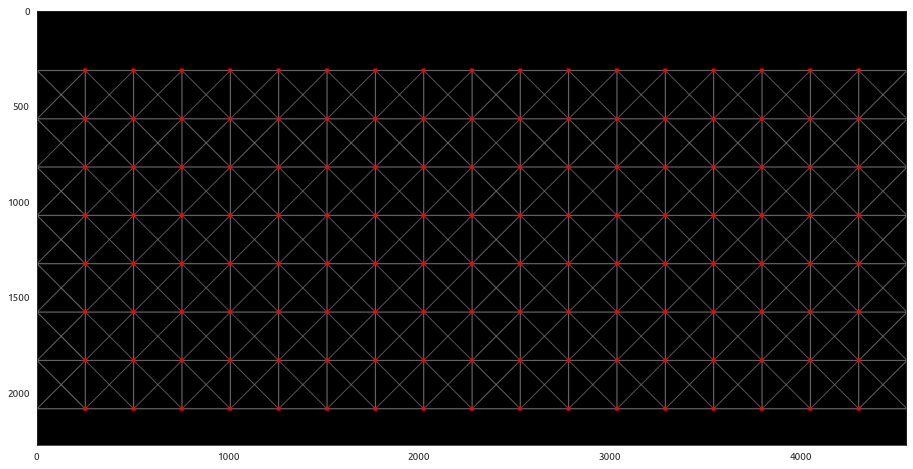

In [6]:
node_dict, canvas = generate_grid(degree = 20)
fig, ax = plt.subplots(figsize=(16,8))

sns.set_style("white")
sns.set_style({'font.family': 'sans-serif',
               'font.sans-serif': 'Ubuntu',
              'font_scale' : 5})


imgplot = plt.imshow(canvas)

In [7]:
ncount = defaultdict(int)
for n in node_dict:
  neighbors = len(set(node_dict[n]['neighbors']))
  ncount[neighbors]+=1
print(ncount)
               

defaultdict(<class 'int'>, {5: 36, 8: 108})
